In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import shutil

# work with images
from skimage.transform import rotate
from skimage import io
from tqdm import tqdm

# model development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Activation, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [3]:
path='../input/histopathologic-cancer-detection/train/'
train_data =pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Data Visualization

In [4]:
print(train_data.shape)

(220025, 2)


<AxesSubplot:>

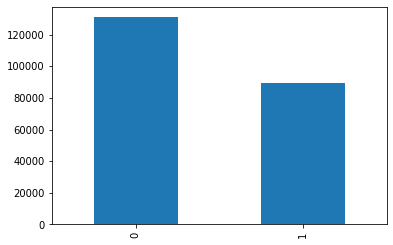

In [5]:
train_data['label'].value_counts().plot(kind='bar')

In [6]:
train_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data.label)

train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [8]:
print(len(train_df['label']))
print(len(valid_df['label']))

165018
55007


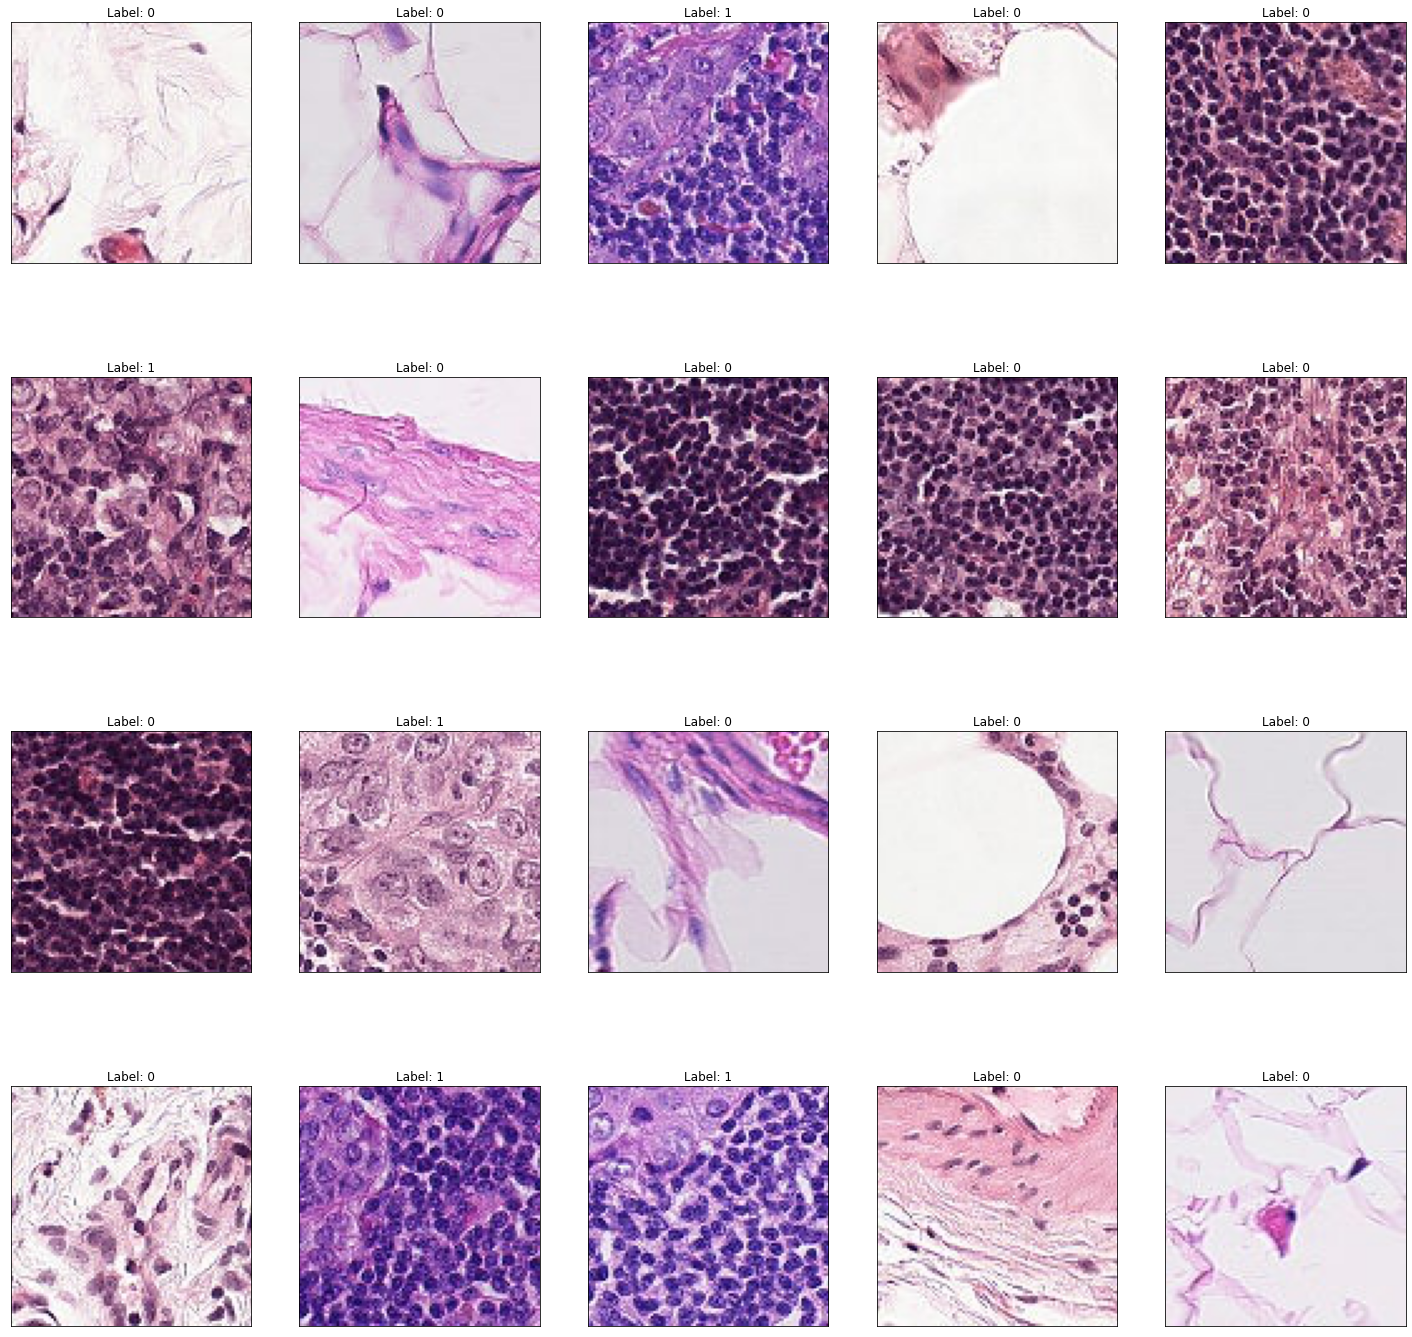

In [9]:
fig = plt.figure(figsize=(25, 25))
train_imgs = os.listdir(path)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open(path + img)
    plt.imshow(im)
    lab = train_data.loc[train_data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

## Loading Data Generators

In [7]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data.label)

train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
  
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255.0)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,directory=path,
                x_col="id",y_col="label",batch_size=64,seed=42,shuffle=False,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_df,directory=path,
                x_col="id",y_col="label",batch_size=64,seed=42,shuffle=False,
                class_mode="binary",target_size=(96,96))


Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


## Baseline Model

In [8]:
#initial model with 4 sets of 2 convolutional layers
model = Sequential()
model.add(Input(shape=(96,96,3)))
model.add(Flatten())
model.add(Dense(768, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.0005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

2022-11-15 17:31:32.070262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 17:31:32.194128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 17:31:32.195020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 17:31:32.196667: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 27648)             0         
_________________________________________________________________
dense (Dense)                (None, 768)               21234432  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 21,235,201
Trainable params: 21,235,201
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50, verbose=1, callbacks= my_callbacks
)

y_pred = model.predict(valid_generator, steps=STEP_SIZE_VALID)

n = len(y_pred)
y_true = valid_df['label'].astype(int).values[:n]

y_pred = y_pred.squeeze()
print(f'AUC: {roc_auc_score(y_true, y_pred)}')

y_pred = [1 if x>=0.5 else 0 for x in y_pred.squeeze()]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy}, Percision: {precision}, Recall {recall}, F1: {f1}')

2022-11-15 17:31:35.500040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
2578/2578 [==============================] - 1265s 490ms/step - loss: 0.7411 - accuracy: 0.5937 - val_loss: 0.6258 - val_accuracy: 0.6175
Epoch 2/50
2578/2578 [==============================] - 330s 128ms/step - loss: 0.6370 - accuracy: 0.6165 - val_loss: 0.6194 - val_accuracy: 0.6281
Epoch 3/50
2578/2578 [==============================] - 332s 129ms/step - loss: 0.6182 - accuracy: 0.6373 - val_loss: 0.6089 - val_accuracy: 0.6289
Epoch 4/50
2578/2578 [==============================] - 329s 128ms/step - loss: 0.6084 - accuracy: 0.6613 - val_loss: 0.5954 - val_accuracy: 0.7043
Epoch 5/50
2578/2578 [==============================] - 331s 129ms/step - loss: 0.5889 - accuracy: 0.6824 - val_loss: 0.5944 - val_accuracy: 0.6378
Epoch 6/50
2578/2578 [==============================] - 330s 128ms/step - loss: 0.5805 - accuracy: 0.6922 - val_loss: 0.5947 - val_accuracy: 0.6868
Epoch 7/50
2578/2578 [==============================] - 328s 127ms/step - loss: 0.5758 - accuracy: 0.6993 - val

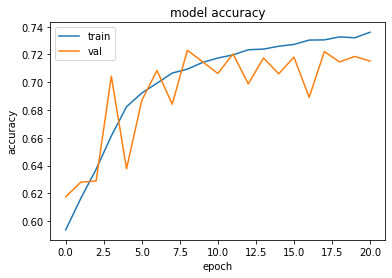

In [10]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

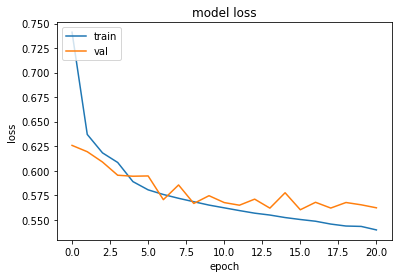

In [11]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Baseline Convolution Model

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

2022-11-15 13:47:01.501892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:47:01.586143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:47:01.586929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:47:01.588140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73729     
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50, verbose=1, callbacks= my_callbacks
)

y_pred = model.predict(valid_generator, steps=STEP_SIZE_VALID)

n = len(y_pred)
y_true = valid_df['label'].astype(int).values[:n]

y_pred = y_pred.squeeze()
print(f'AUC: {roc_auc_score(y_true, y_pred)}')

y_pred = [1 if x>=0.5 else 0 for x in y_pred.squeeze()]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy}, Percision: {precision}, Recall {recall}, F1: {f1}')

2022-11-15 13:47:04.658502: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-15 13:47:06.346617: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2578/2578 [==============================] - 1139s 439ms/step - loss: 0.4641 - accuracy: 0.7871 - val_loss: 0.4266 - val_accuracy: 0.8083
Epoch 2/50
2578/2578 [==============================] - 337s 131ms/step - loss: 0.4220 - accuracy: 0.8111 - val_loss: 0.4373 - val_accuracy: 0.8062
Epoch 3/50
2578/2578 [==============================] - 321s 125ms/step - loss: 0.3943 - accuracy: 0.8255 - val_loss: 0.4072 - val_accuracy: 0.8213
Epoch 4/50
2578/2578 [==============================] - 340s 132ms/step - loss: 0.3704 - accuracy: 0.8386 - val_loss: 0.4034 - val_accuracy: 0.8198
Epoch 5/50
2578/2578 [==============================] - 397s 154ms/step - loss: 0.3511 - accuracy: 0.8479 - val_loss: 0.4236 - val_accuracy: 0.8228
Epoch 6/50
2578/2578 [==============================] - 335s 130ms/step - loss: 0.3346 - accuracy: 0.8565 - val_loss: 0.4138 - val_accuracy: 0.8242
Epoch 7/50
2578/2578 [==============================] - 323s 125ms/step - loss: 0.3232 - accuracy: 0.8617 - val_loss: 0.46

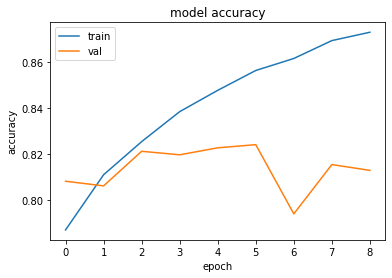

In [14]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

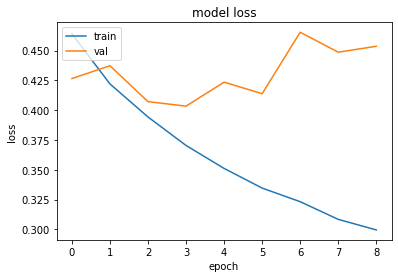

In [15]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## ResNet50

In [19]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data.label)

train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
  
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255.0, horizontal_flip=True, vertical_flip=True, preprocessing_function=preprocess_input)
valid_datagen=ImageDataGenerator(rescale=1/255.0, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,directory=path,
                x_col="id",y_col="label",batch_size=64,shuffle=False,
                class_mode="binary",target_size=(96,96))

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,directory=path,
                x_col="id",y_col="label",batch_size=64,shuffle=False,
                class_mode="binary",target_size=(96,96))

inputs = Input((96, 96, 3))
base_model = ResNet50(include_top=False, input_shape=(96, 96, 3), weights=None)
x = base_model(inputs)

out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)

out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.2)(out)
out = Dense(1, activation="sigmoid", name="3_")(out)
model = Model(inputs, out)
model.compile(optimizer=Adam(0.00003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50, verbose=1, callbacks= my_callbacks
)

y_pred = model.predict(valid_generator, steps=STEP_SIZE_VALID)

n = len(y_pred)
y_true = valid_df['label'].astype(int).values[:n]

y_pred = y_pred.squeeze()
print(f'AUC: {roc_auc_score(y_true, y_pred)}')

thres = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_acc = 0
max_thres = 0
for t in thres:
    temp = [1 if x>=t else 0 for x in y_pred.squeeze()]
    accuracy = accuracy_score(y_true, temp)
    if accuracy > max_acc:
        max_acc = accuracy
        max_thres = t

        
    
y_pred = [1 if x>=max_thres else 0 for x in y_pred.squeeze()]
res_preds = y_pred.copy()

accuracy = accuracy_score(y_true, y_pred)   
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy}, Percision: {precision}, Recall {recall}, F1: {f1}')

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


2022-12-19 16:08:38.120284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:08:38.266155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:08:38.266953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 16:08:38.269568: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 3, 3, 2048)   23587712    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           resnet50[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           resnet50[0][0]                   
______________________________________________________________________________________________

2022-12-19 16:08:42.891220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-19 16:08:48.683933: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2578/2578 [==============================] - 1143s 439ms/step - loss: 0.5735 - accuracy: 0.7548 - val_loss: 0.4351 - val_accuracy: 0.8072
Epoch 2/50
2578/2578 [==============================] - 370s 144ms/step - loss: 0.4417 - accuracy: 0.8085 - val_loss: 1.0944 - val_accuracy: 0.8304
Epoch 3/50
2578/2578 [==============================] - 363s 141ms/step - loss: 0.4060 - accuracy: 0.8298 - val_loss: 0.4733 - val_accuracy: 0.8372
Epoch 4/50
2578/2578 [==============================] - 362s 140ms/step - loss: 0.3586 - accuracy: 0.8523 - val_loss: 0.5606 - val_accuracy: 0.7573
Epoch 5/50
2578/2578 [==============================] - 363s 141ms/step - loss: 0.3329 - accuracy: 0.8650 - val_loss: 0.2907 - val_accuracy: 0.8788
Epoch 6/50
2578/2578 [==============================] - 363s 141ms/step - loss: 0.2821 - accuracy: 0.8853 - val_loss: 0.2739 - val_accuracy: 0.8990
Epoch 7/50
2578/2578 [==============================] - 368s 143ms/step - loss: 0.2691 - accuracy: 0.8919 - val_loss: 0.22

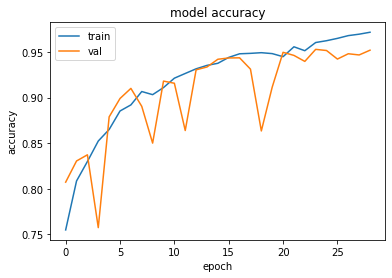

In [20]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

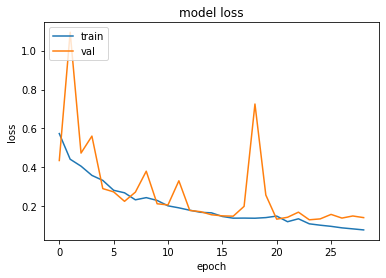

In [21]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## InceptionV3

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data.label)

train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
  
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255.0, horizontal_flip=True, vertical_flip=True, preprocessing_function=preprocess_input)
valid_datagen=ImageDataGenerator(rescale=1/255.0, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,directory=path,
                x_col="id",y_col="label",batch_size=64,shuffle=False,
                class_mode="binary",target_size=(96,96))

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,directory=path,
                x_col="id",y_col="label",batch_size=64,shuffle=False,
                class_mode="binary",target_size=(96,96))


inputs = Input((96, 96, 3))
base_model = InceptionV3(include_top=False, input_shape=(96, 96, 3), weights=None)
x = base_model(inputs)

out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)

out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.2)(out)
out = Dense(1, activation="sigmoid", name="3_")(out)
model = Model(inputs, out)
model.compile(optimizer=Adam(0.00003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50, verbose=1, callbacks= my_callbacks
)

y_pred = model.predict(valid_generator, steps=STEP_SIZE_VALID)

n = len(y_pred)
y_true = valid_df['label'].astype(int).values[:n]

y_pred = y_pred.squeeze()
print(f'AUC: {roc_auc_score(y_true, y_pred)}')

thres = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_acc = 0
max_thres = 0
for t in thres:
    temp = [1 if x>=t else 0 for x in y_pred.squeeze()]
    accuracy = accuracy_score(y_true, temp)
    if accuracy > max_acc:
        max_acc = accuracy
        max_thres = t

        
    
y_pred = [1 if x>=max_thres else 0 for x in y_pred.squeeze()]
inception_preds = y_pred.copy()

accuracy = accuracy_score(y_true, y_pred)   
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy}, Percision: {precision}, Recall {recall}, F1: {f1}')

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 1, 1, 2048)   21802784    input_3[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)         0           inception_v3[0][0]               
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           i

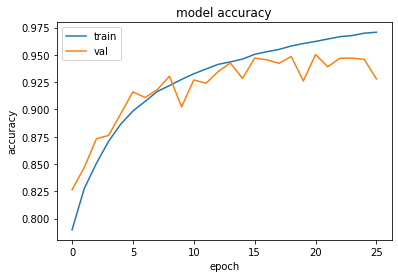

In [23]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

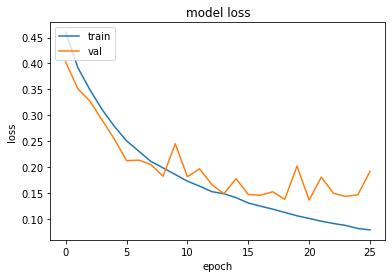

In [24]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Majority Ensemble

In [25]:
# MAJORITY
y_pred = [sum(x) for x in zip(res_preds, inception_preds)]
y_pred = [1 if x >= 1 else 0 for x in y_pred]

accuracy = accuracy_score(y_true, y_pred)   
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy}, Percision: {precision}, Recall {recall}, F1: {f1}')

Accuracy: 0.9465948777648429, Percision: 0.9051691611118098, Recall 0.969728273074332, F1: 0.9363372219090159


## Concatenation Ensemble

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import preprocess_input

train_df, valid_df = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data.label)

train_df['id'] = train_df['id']+'.tif'
valid_df['id'] = valid_df['id']+'.tif'

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)
  
#create the training and validation subsets
train_datagen=ImageDataGenerator(rescale=1/255.0, horizontal_flip=True, vertical_flip=True, preprocessing_function=preprocess_input)
valid_datagen=ImageDataGenerator(rescale=1/255.0, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,directory=path,
                x_col="id",y_col="label",batch_size=64,shuffle=False,
                class_mode="binary",target_size=(96,96))

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,directory=path,
                x_col="id",y_col="label",batch_size=64,shuffle=False,
                class_mode="binary",target_size=(96,96))

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
inputs = Input((96, 96, 3))
base_model_eff = InceptionV3(include_top=False, input_shape=(96, 96, 3), weights=None)
base_model_resnet = ResNet50(include_top=False, input_shape=(96, 96, 3), weights=None)

x1 = base_model_eff(inputs)
x2 = base_model_resnet(inputs)

out1 = GlobalMaxPooling2D()(x1)
out2 = GlobalAveragePooling2D()(x1)
out3 = Flatten()(x1)

out = Concatenate(axis=-1)([out1, out2, out3])
out_eff = Dropout(0.2)(out)

out1 = GlobalMaxPooling2D()(x2)
out2 = GlobalAveragePooling2D()(x2)
out3 = Flatten()(x2)

out = Concatenate(axis=-1)([out1, out2, out3])
out_res = Dropout(0.2)(out)


out = Concatenate(axis=-1)([out_eff, out_res])
out = Dense(1, activation="sigmoid", name="3_")(out)
model = Model(inputs, out)


model.compile(optimizer=Adam(0.00003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



2022-12-19 00:22:18.113974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 00:22:18.261876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 00:22:18.262669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 00:22:18.264570: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 1, 1, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 3, 3, 2048)   23587712    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           inception_v3[0][0]               
______________________________________________________________________________________________

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=70, verbose=1, callbacks= my_callbacks
)

y_pred = model.predict(valid_generator, steps=STEP_SIZE_VALID)

n = len(y_pred)
y_true = valid_df['label'].astype(int).values[:n]

y_pred = y_pred.squeeze()
print(f'AUC: {roc_auc_score(y_true, y_pred)}')

thres = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_acc = 0
max_thres = 0
for t in thres:
    temp = [1 if x>=t else 0 for x in y_pred.squeeze()]
    accuracy = accuracy_score(y_true, temp)
    if accuracy > max_acc:
        max_acc = accuracy
        max_thres = t

        
    
y_pred = [1 if x>=max_thres else 0 for x in y_pred.squeeze()]

accuracy = accuracy_score(y_true, y_pred)   
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {accuracy}, Percision: {precision}, Recall {recall}, F1: {f1}')

2022-12-19 00:22:24.556615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-12-19 00:22:37.299202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2578/2578 [==============================] - 1077s 410ms/step - loss: 0.5364 - accuracy: 0.7694 - val_loss: 0.4379 - val_accuracy: 0.8132
Epoch 2/70
2578/2578 [==============================] - 518s 201ms/step - loss: 0.4429 - accuracy: 0.8101 - val_loss: 0.4073 - val_accuracy: 0.8323
Epoch 3/70
2578/2578 [==============================] - 519s 201ms/step - loss: 0.3913 - accuracy: 0.8365 - val_loss: 0.3771 - val_accuracy: 0.8528
Epoch 4/70
2578/2578 [==============================] - 516s 200ms/step - loss: 0.3536 - accuracy: 0.8553 - val_loss: 0.3447 - val_accuracy: 0.8514
Epoch 5/70
2578/2578 [==============================] - 518s 201ms/step - loss: 0.3179 - accuracy: 0.8708 - val_loss: 0.2850 - val_accuracy: 0.8821
Epoch 6/70
2578/2578 [==============================] - 517s 201ms/step - loss: 0.2893 - accuracy: 0.8844 - val_loss: 1.2991 - val_accuracy: 0.8359
Epoch 7/70
2578/2578 [==============================] - 519s 201ms/step - loss: 0.2658 - accuracy: 0.8950 - val_loss: 0.28

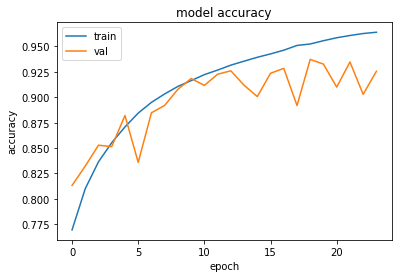

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

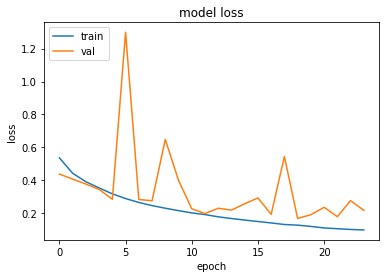

In [ ]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()